# μA78L05 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/UA78L05.ipynb

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [3]:
# NgSpice
import ngspyce as ng

In [4]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

In [5]:
def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

## Schematic

The internal schematic is from [_1977 Signetics Analog Data Manual_](http://www.bitsavers.org/components/signetics/_dataBooks/1977_Signetics_Analog_Data_Manual.pdf) p.160.

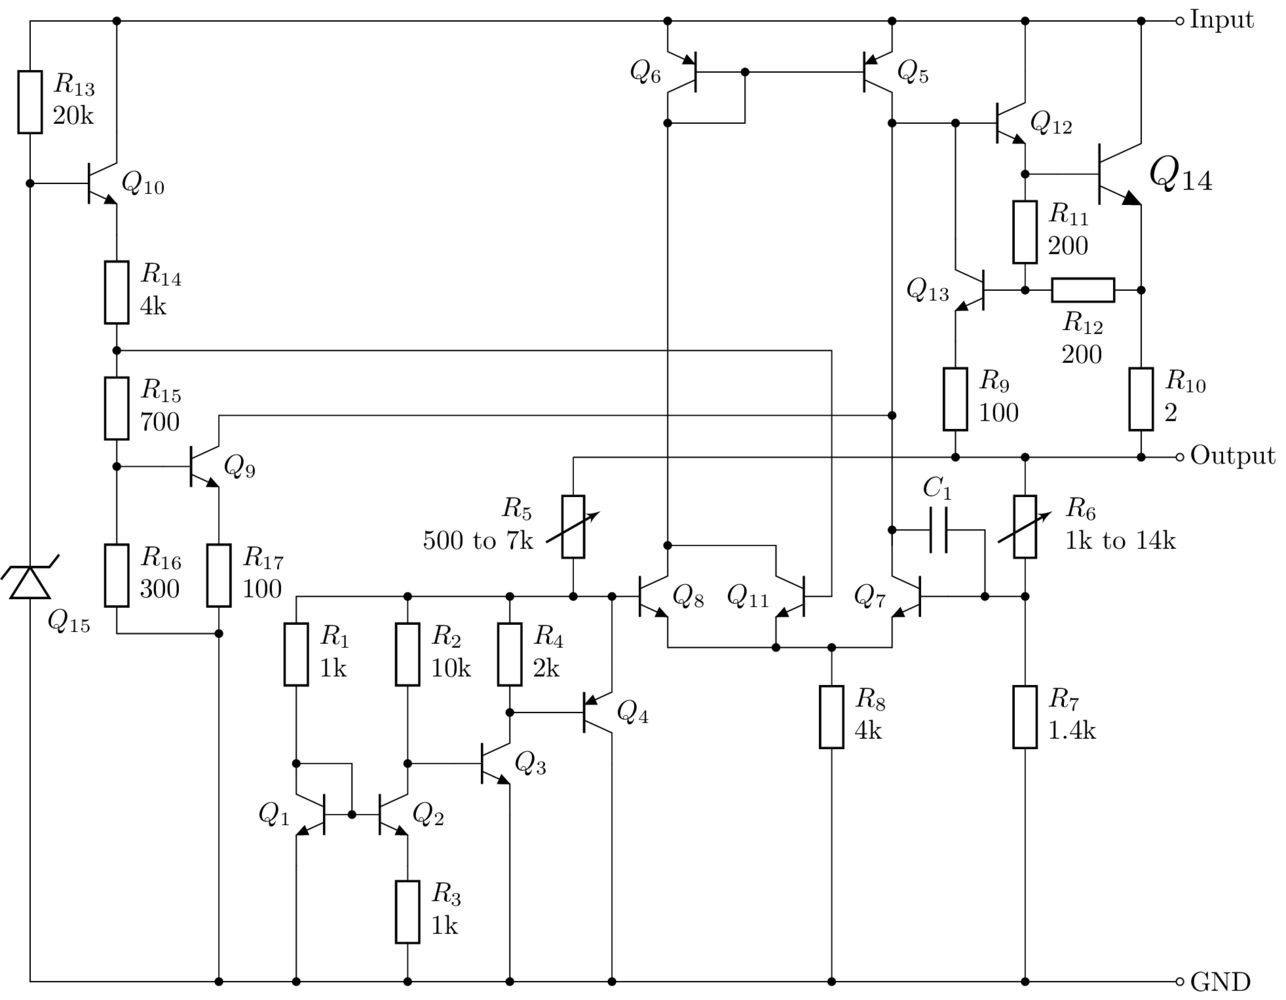

### Simplified

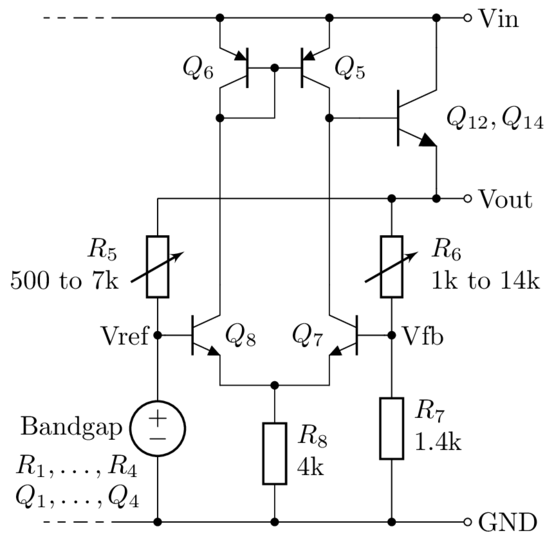

**Estimate the reference voltage**

* $R_6$ sets the output voltage, Vfb = Vref when balanced.
* μA78Lxx series has maximum output voltage of 15V, so I guess $R_6=14$kΩ when Vout=15V.
* Vfb = $\dfrac{1.4}{1.4+14}\times 15 = 15 / 11 = 1.364$V
* Then Vref = 1.364V


### Overly simplified

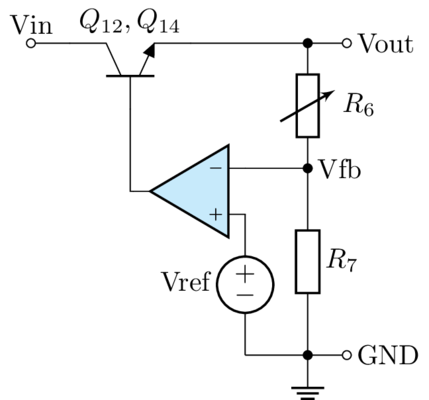

## Bandgap voltage reference

To be continued...